# Look-One-Ahead Cross-Validation

When we estimate the parameters of a reinforcement learning (RL) model from behavioural data, we assume (or merely hope) that sampling new behaviours from that model will closely approximate those of the original subject. Testing this assumption can be done with cross-validation. However, how one should approach cross-validation is not a clear-cut decision. 

At present, `fitr` implements a procedure called _Look-One-Ahead Cross-Validation_ (LOACV). 

## Basic Intuition

As always, we begin with a set of behavioural data $\mathcal{D} = \lbrace \mathcal{S}, \mathcal{A}, \mathcal{R} \rbrace$, for $N$ subjects, where 

- $\mathcal{S} = \lbrace \mathbf{S}_i \rbrace_{i=1}^N$ denotes the set of states encountered by all subjects, 
- $\mathcal{A} = \lbrace \mathbf{A}_i \rbrace_{i=1}^N$ denotes the corrresponding actions, and
- $\mathcal{R} = \lbrace \mathbf{R}_i \rbrace_{i=1}^N$ denotes the corresponding rewards.

To simplify this explanation, let us consider the case where we have the $i$'th subject's data over $T$ trials of the task:

- $\mathbf{S}_i = \lbrace s_t \rbrace_{t=1}^T$ are the states encountered by subject $i$,
- $\mathbf{A}_i = \lbrace a_t \rbrace_{t=1}^T$ are the actions taken by subject $i$, and
- $\mathbf{R}_i = \lbrace r_t \rbrace_{t=1}^T$ are the rewards received by subject $i$.

In the RL modeling framework, we assume that the sequence of actions taken by subject $i$ are conditionally independent given the states encountered, then we can write

$$
\mathbf{A}_i \sim P(\mathbf{A} | \boldsymbol\theta_i),
$$

which is the likelihood of a set of actions $\mathbf{A}$ given subject $i$'s parameters, $\boldsymbol\theta_i$.

Let $\hat{\boldsymbol\theta}_i$ represent parameters that have been estimated by model-fitting for subject $i$. If these parameters have been well estimated, then we would expect that the likelihood of the subject's data, would be similar under either the original or estimated parameters:

$$
P(\mathbf{A}_i | \boldsymbol\theta_i) \approx P(\mathbf{A}_i | \hat{\boldsymbol\theta}_i).
$$

In cross-validation, however, we want to test this fit by determining whether actions sampled from the likelihood function under the estimated parameters, $P(\mathbf{A} | \hat{\boldsymbol\theta}_i)$, accurately reflect the actions observed from the subject's behaviour.

We therefore need to instantiate a model with the estimated parameters and sample actions from that model. We can then compare the actions predicted by the model against the actions actually taken by the subject. 

### Accounting for Learning 

If we were to simply run the model on the task (assuming this task has probabilistic outcomes), then the model's trajectory of states, actions, and rewards may deviate dramatically from that actually observed by the subject. That is, even if the model is making the same decisions as the subject early on, a probabilistic delivery or omission of reward that differs from the subject's experience could result in the model learning a value function or policy that takes it in a totally different trajectory. This could result in poor cross-validation performance, even though the parameter estimates and model architecture might be excellent. 

To address this problem, we use LOACV, which functions as depicted in the following code:

``` python 
import numpy as np

def LOACV_Pseudocode(params, states, actions, rewards):
    """
    params : array [1 by N_Params]
        Array of parameter estimates for the given subject
    states : array [T by 1]
        Array of states encountered at each time step by the subject
    actions : array [T by 1]
        Array of actions taken by the subject at each time step 
    rewards : array [T by 1]
        Array of rewards received by the subject at each time step
        
    Note
    ----
    T = total number of time steps
    n_states = number of states in the task
    n_actions = number of actions that can be taken at each state
    """
    
    # We will assume there are two parameters for this task
    lr = params[0] # Learning rate
    cr = params[1] # Inverse softmax temperature
    
    # Instantiate the state-action value table
    Q = np.zeros((n_states, n_actions))
    
    # Create vector to store predicted/true action comparison
    accuracy_vec = np.zeros(T) 
    
    for t in range(T):
        # Extract subject i's state, action, and reward at time t
        s_t = states[t] 
        a_t = actions[t]
        r_t = rewards[t]
        
        # Based on the model's Q function and parameters, sample 
        #  the action it predicts (i.e. a_pred)
        a_pred = ActionSelection(cr*Q[s_t, :])
        
        # Compare the true action with the predicted action
        #  and store the result in the accuracy_vec array
        accuracy_vec[t] = (a_t == a_pred)
        
        # Learn the value function:
        #   Note that the value function is learned based on
        #   the states, actions, and rewards that were 
        #   actually received by the subject, but using the 
        #   estimated parameters!
        RPE = r_t - Q[s_t, a_t]
        Q[s_t, a_t] = Q[s_t, a_t] + lr*RPE
    
    # Compute overall accuracy score:
    #  This is just one example of a potential measure. Other
    #  accuracy metrics (e.g. weighted) could be used.
    mean_accuracy = np.mean(accuracy_vec)
    
    return mean_accuracy
```

Note that this function as written above cannot be run directly since there are many undeclared variables. It was written not to function, but to give you the intuition behind the procedure.

## Working Example using `fitr`

Now that you hopefully have a basic understanding of the LOACV procedure, we will demonstrate how simple this is to run in `fitr`. First, let's import the necessary packages and modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from fitr.rlparams import LearningRate
from fitr.rlparams import ChoiceRandomness
from fitr.rlparams import Perseveration
from fitr.models import driftbandit
from fitr.inference import MLE
from fitr.model_selection import LOACV

The task upon which this will be implemented is a simple two-armed bandit task, where the reward probabilities drift according to Gaussian random walks over the trials. The analogous situation here is that one has a choice between two slot-machines, and she has 200 attempts to play. At each time step, only one slot machine may be chosen. When played, each slot machine has a probability of paying out \$1 or nothing. Unfortunately for the gambler, the probabilities at each machine change slowly after each time-step (with a minimum probability of 25\% and a maximum probability of 75\% at any given time). As such, the gambler must play at the best slot machine more often, but still explore the other slot machine in order to know which one is best at any given time. 

### Step 1: Create some simulated data

Here, we will create some simulated data from $N=50$ subjects who play the two-armed bandit task for a total of $T=200$ trials, each. We assume that these subjects make decisions according to an RL model with the parameters $\boldsymbol\theta = \lbrace \alpha_i, \beta_i, p_i \rbrace_{i=1}^N$, where 

- $\alpha_i$ is the Learning Rate for subject $i$
- $\beta_i$ is the inverse softmax temperature (aka Choice Randomness) for subject $i$, and 
- $p_i$ is the perseveration parameter for subject $i$. 

These operate through the following equations. First, the observation model (aka. "link function") is

$$
P\big(a_t \big| \mathcal{Q}_t(s_t, a_t; \boldsymbol\theta_i)\big) = \frac{\exp \Bigg\lbrace \beta_i \Big(\mathcal{Q}_t(s_t, a_t; \alpha_i) + p_i \cdot rep(a_t) \Big) \Bigg\rbrace}{\sum_{a'} \exp \Bigg\lbrace \beta_i \Big(\mathcal{Q}_t(s_t, a'; \alpha_i) + p_i \cdot rep(a') \Big) \Bigg\rbrace }, 
$$

where 

$$
rep(a) = 
\left \{ 
\begin{array}{ll}
1 & \text{  if } a = a_t \\
0 & \text{  else} \\
\end{array}
\right.
$$

multiplied by a perseveration parameter $p_i$ denotes the tendency of the subject to repeat previous actions irrespective of their value.

The learning model here is a simple Rescorla-Wagner learning rule:

$$
\mathcal{Q}_t(s_t, a_t; \alpha_i) = \mathcal{Q}_{t-1}(s_t, a_t; \alpha_i) + \alpha_i \Big(r_t - \mathcal{Q}_{t-1}(s_t, a_t; \alpha_i) \Big)
$$

This model is implemented in the ``fitr.models.driftbandit.lr_cr_p`` class, which we use in this example henceforth.

In [2]:
N = 50
T = 100
n_arms = 2

# Define task model
task = driftbandit.lr_cr_p(narms=2)

# Simulate data
group_data = task.simulate(nsubjects=N, ntrials=T) 

### Step 2: Cross-Validation with True Parameters 

Before we cross-validate estimated parameters, it is of interest to determine how well the true parameters perform.

First, we will instantiate the `LOACV()` object with the Look-One-Ahead cross-validation function included in the `driftbandit.lr_cr_p` class.

In [3]:
cv_true = LOACV(cv_func=task.loacv)

Now we can run the cross validation using the parameters and data as arguments for the `LOACV().run()` function.

In [4]:
cv_true.run(params=group_data.params, data=group_data.data)

The results can be plotted as a histogram of cross-validation accuracy,

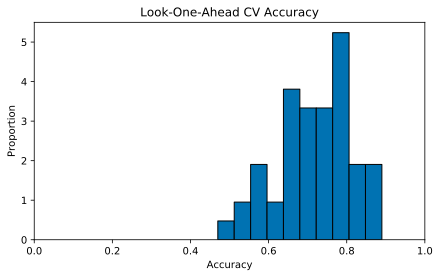

In [5]:
fig = cv_true.results.accuracy_hist(figsize=(7, 4))

or as a moving average of accuracy (over all timesteps taken), 

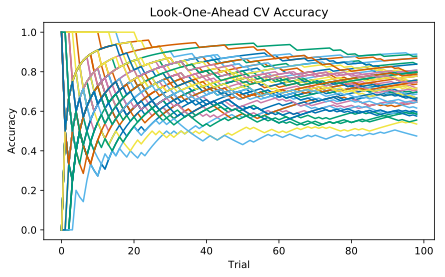

In [6]:
fig = cv_true.results.accuracy_maplot(figsize=(7, 4))

or as scatterplots comparing the parameters with the accuracy estimates.

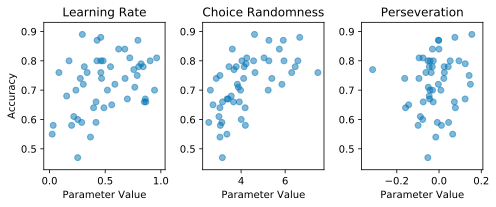

In [7]:
fig = cv_true.results.accuracy_param_scatter(paramnames=['Learning Rate', 
                                                         'Choice Randomness', 
                                                         'Perseveration'],
                                            figsize=(7, 3))

### Step 3: Perform Model Fitting to Infer Parameters

We will attempt parameter recovery using Empirical Priors here:

In [8]:
mle = MLE(loglik_func=task.loglikelihood, 
        params=[LearningRate(), ChoiceRandomness(), Perseveration()])
mlefit = mle.fit(data=group_data.data, verbose=False)

     MODEL: MLEModel
     METHOD: Maximum Likelihood
     ITERATIONS: 1000
     OPTIMIZATION ALGORITHM: L-BFGS-B
     VERBOSE: False


 MODEL FITTING COMPLETED 



### Step 4: Cross-Validation with Inferred Model Parameters 

Now we can perform cross-validation once again with the recovered parameters.

In [9]:
cv_mle = LOACV(cv_func=task.loacv)
cv_mle.run(params=mlefit.params, data=group_data.data)

Once again, we can plot the results.

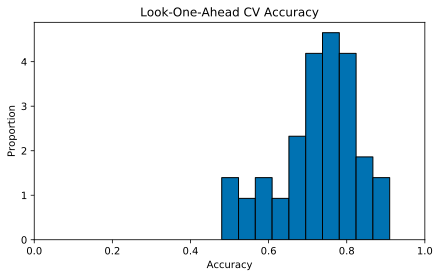

In [10]:
fig = cv_mle.results.accuracy_hist(figsize=(7, 4))

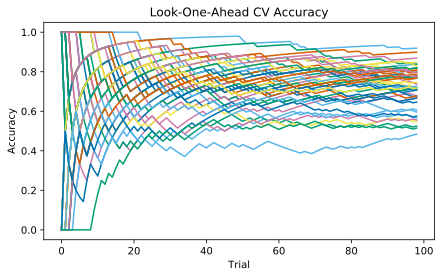

In [11]:
fig = cv_mle.results.accuracy_maplot(figsize=(7, 4))

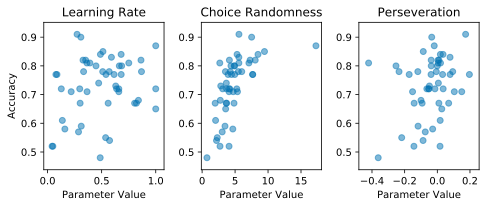

In [12]:
fig = cv_mle.results.accuracy_param_scatter(paramnames=['Learning Rate', 
                                                        'Choice Randomness', 
                                                        'Perseveration'], 
                                           figsize=(7, 3))